# Coronavirus - Estimating Case Fatality Ratio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os, re, pickle

from pydemic import Epidemic, Outbreak

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.rcParams['figure.figsize']=[40,20]

plt.style.use('seaborn-whitegrid')

### Setup

In [4]:
coronavirus_confirmed_df = pd.read_csv("../data/clean/coronavirus_confirmed_global.csv", index_col=0)
coronavirus_death_df = pd.read_csv("../data/clean/coronavirus_death_global.csv", index_col=0)
coronavirus_recovered_df = pd.read_csv("../data/clean/coronavirus_recovered_global.csv", index_col=0)

In [6]:
epidemic = Epidemic("Coronavirus", coronavirus_confirmed_df, coronavirus_death_df, coronavirus_recovered_df)
top10_countries = epidemic.get_top_regions(top_n=10, exclude=["China", "Iran"])
top20_countries = epidemic.get_top_regions(top_n=20, exclude=["China", "Iran"])

## Simple Estimators

In [7]:
def plot_estimator_curve(outbreak, estimator, **kwargs):
    curve = [estimator(outbreak, t) for t in range(outbreak.duration)]
    
    plt.plot(curve, label=outbreak.region, **kwargs)
    
    return 0

### Naive CFR

This is the simplest CFR estimator. It uses aggreate data of fatalities and cases at a given point in time.

In [8]:
def nCFR(outbreak, t):
    if t > outbreak.duration:
        return np.nan
    
    return outbreak.cumulative_fatality_curve[t] / outbreak.cumulative_epidemic_curve[t]

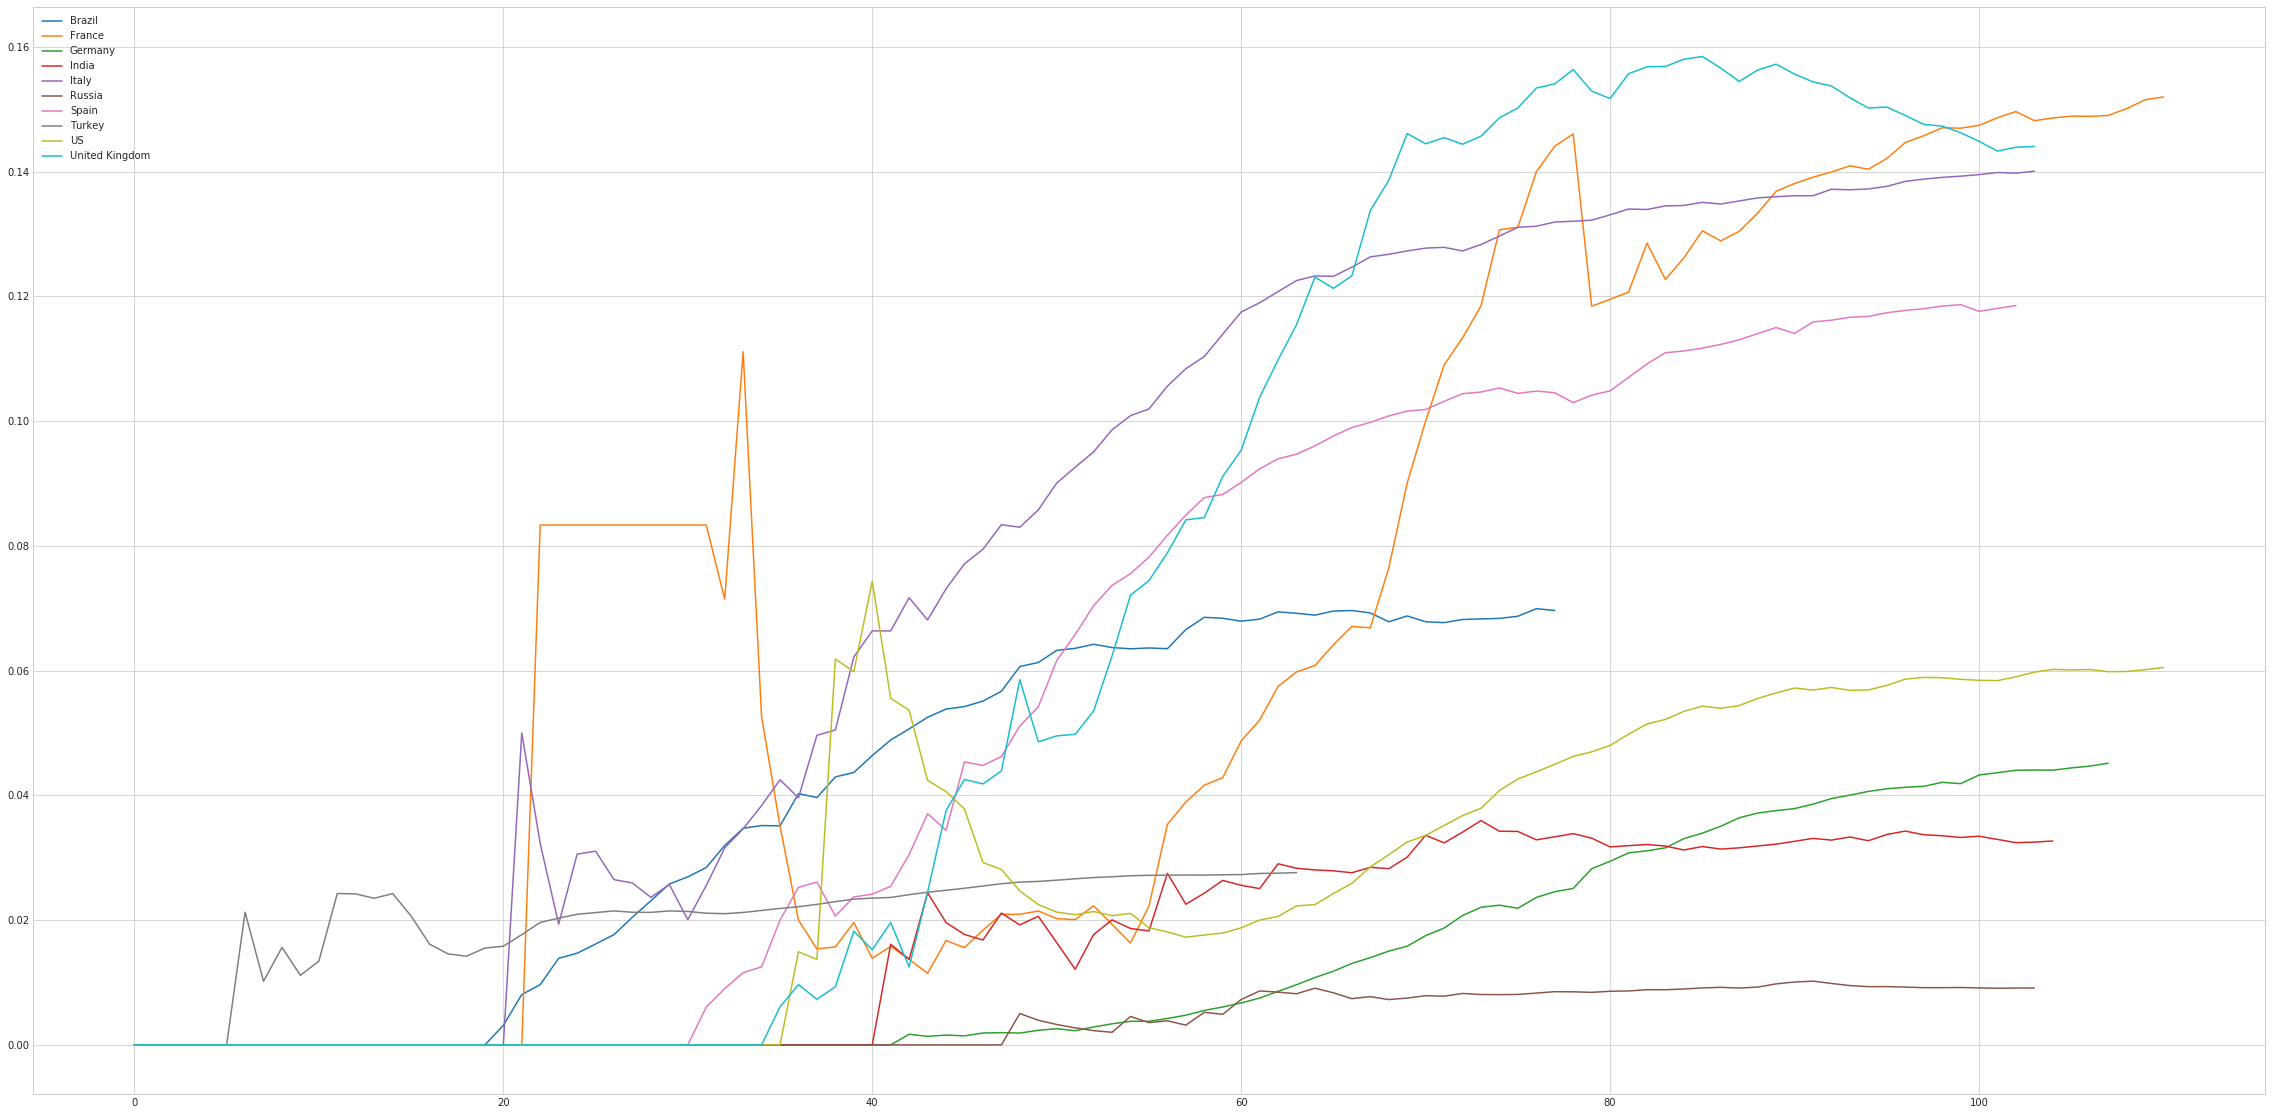

In [9]:
epidemic.apply(plot_estimator_curve, nCFR, regions=top10_countries)
plt.legend()
plt.show()

### Outcome-controlled Naive CFR

As seen on [2005 Guani](http://localhost:8888/notebooks/nbs/literature_review.ipynb#Methods-for-Estimating-the-Case-Fatality-Ratio-for-a-Novel,-Emerging-Infectious-Disease), this estimator will control for the censored data by only considering the resolved cases. 

A **resolved** case is one that has a known outcome of either *death* or *recovery*, whereas an **active** case is one for which no event has occured as of given time period $t$ (therefore, right-censored).

Therefore, the first assumption for this estimator is that the CFR for active cases will be similar in distribution than that of resolved cases.

Furthermore, another assumption that needs to be met for this estimator to work well is that "the hazards of death and recovery at any time $k$ from onset, conditional on an event occuring at time $k$, are proportional".

In [27]:
def outcome_controlled_nCFR(outbreak, t):
    if t > outbreak.duration:
        return np.nan
    
    return outbreak.cumulative_fatality_curve[t] / (outbreak.cumulative_recovery_curve[t] + outbreak.cumulative_fatality_curve[t])

<ipython-input-27-901c93ef1029>:5: RuntimeWarning: invalid value encountered in double_scalars
  return outbreak.cumulative_fatality_curve[t] / (outbreak.cumulative_recovery_curve[t] + outbreak.cumulative_fatality_curve[t])
<ipython-input-27-901c93ef1029>:5: RuntimeWarning: invalid value encountered in double_scalars
  return outbreak.cumulative_fatality_curve[t] / (outbreak.cumulative_recovery_curve[t] + outbreak.cumulative_fatality_curve[t])
<ipython-input-27-901c93ef1029>:5: RuntimeWarning: invalid value encountered in double_scalars
  return outbreak.cumulative_fatality_curve[t] / (outbreak.cumulative_recovery_curve[t] + outbreak.cumulative_fatality_curve[t])
<ipython-input-27-901c93ef1029>:5: RuntimeWarning: invalid value encountered in double_scalars
  return outbreak.cumulative_fatality_curve[t] / (outbreak.cumulative_recovery_curve[t] + outbreak.cumulative_fatality_curve[t])
<ipython-input-27-901c93ef1029>:5: RuntimeWarning: invalid value encountered in double_scalars
  return 

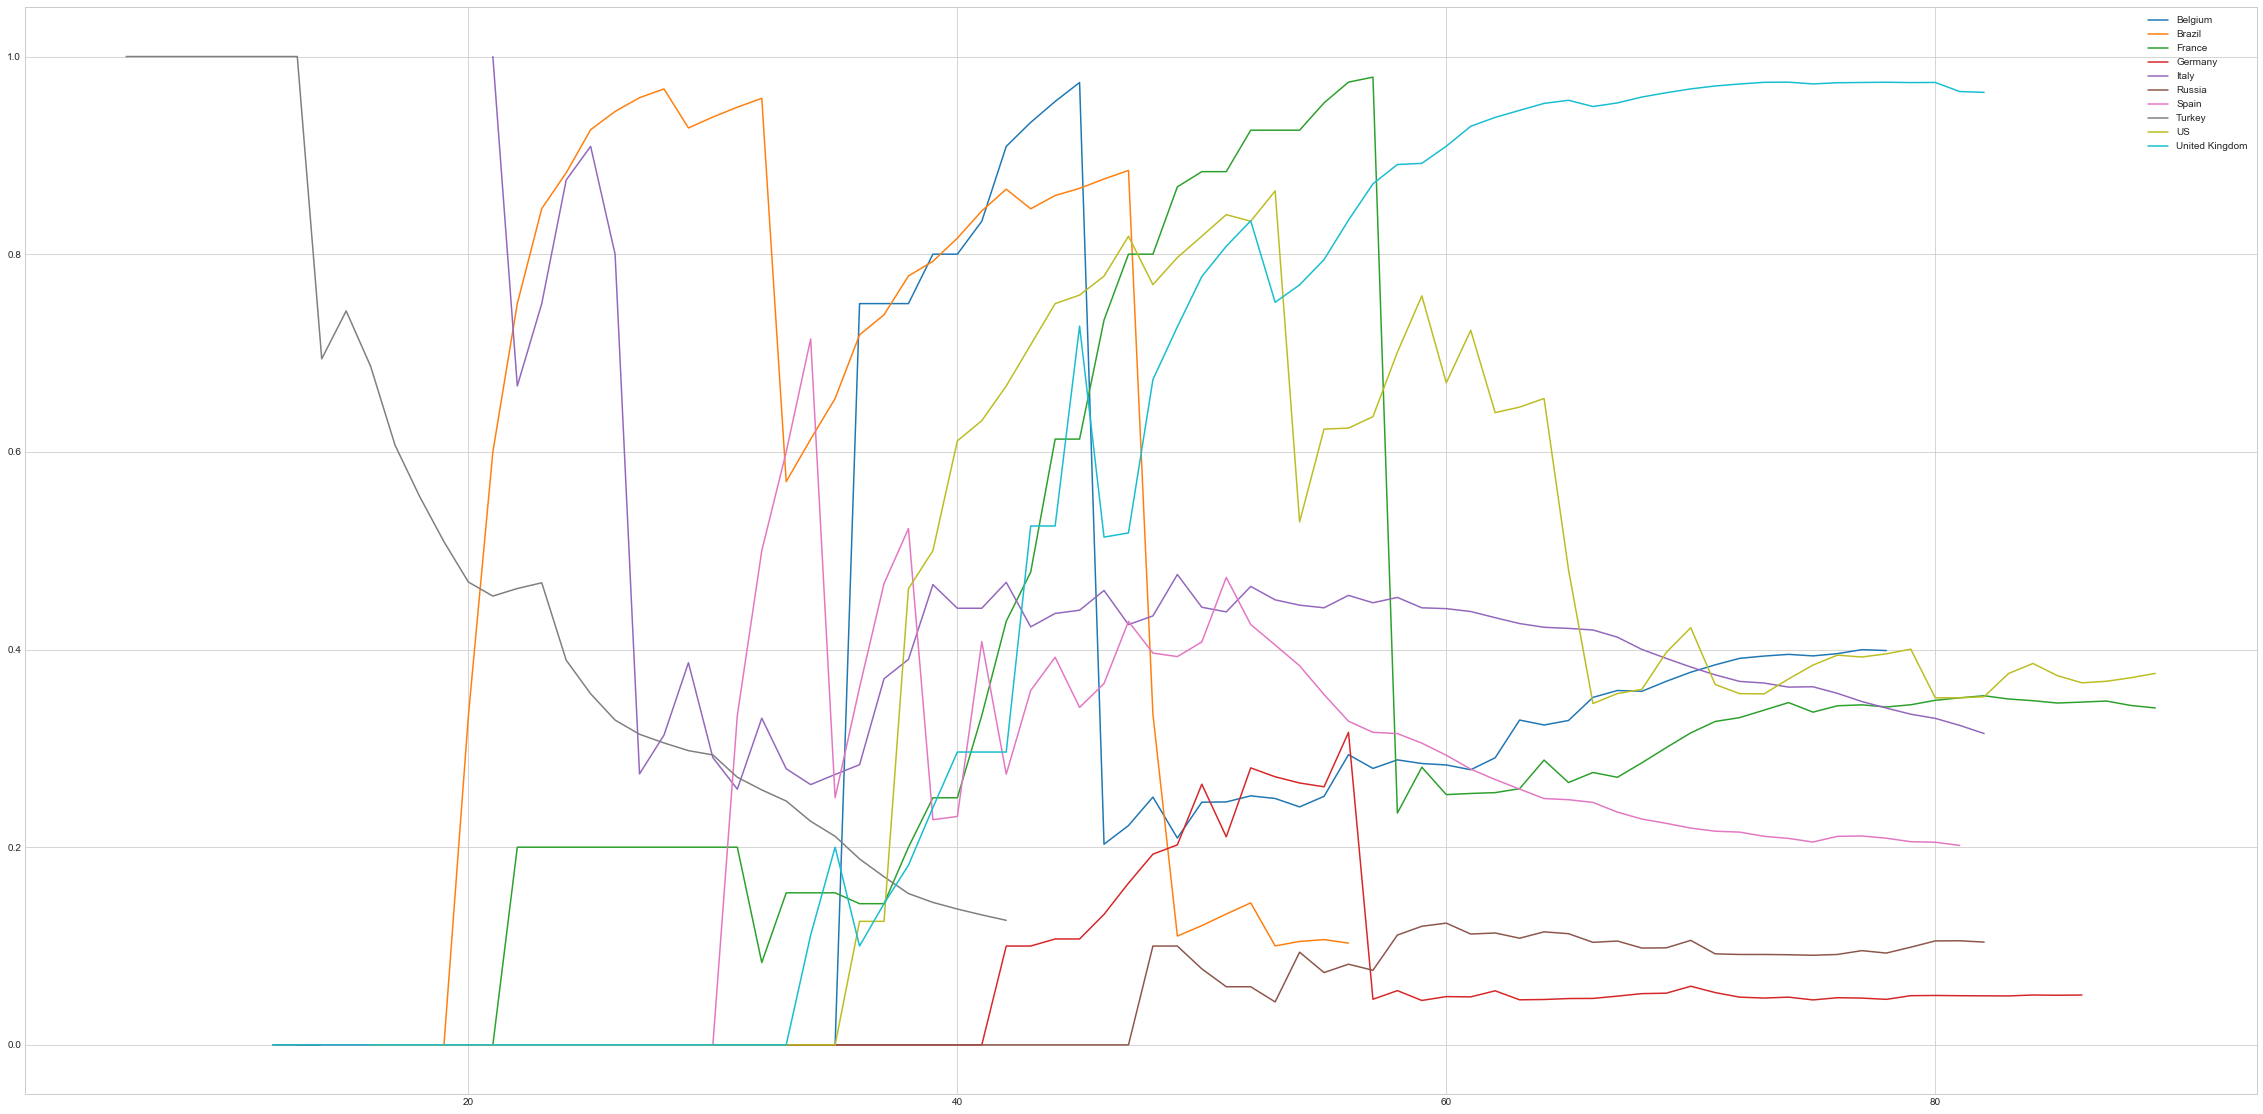

In [28]:
epidemic.apply(plot_estimator_curve, outcome_controlled_nCFR, regions=top10_countries)
plt.legend()
plt.show()

### Parametric Mixture Models

As seen on [2005 Guani](http://localhost:8888/notebooks/nbs/literature_review.ipynb#Methods-for-Estimating-the-Case-Fatality-Ratio-for-a-Novel,-Emerging-Infectious-Disease). This seems powerful, yet cannot be applied to our case as we are missing patient level data.

### Underestimate-Corrected Support

In [1]:
from scipy.optimize import fsolve
from scipy.special import gamma

# this distribution is useful as a baseline for the potential parameters we will encounter
# based on some paper
def estimate_weibull_parameters(mu=8.9, std=5.4, k_0=1):
    def optimization_problem(k):
        return (std / mu)**2 - (gamma(1+ 2/k) / gamma(1+ 1/k)) ** 2 + 1;

    # solve for k
    k = fsolve(optimization_problem, k_0)[0]   
    # solve for lambda
    l = mu / gamma(1 + 1/k) 
    
    return k, l

beta_star, lam_star = estimate_weibull_parameters()

In [ ]:
def known_outcome_adjusted_CFR(outbreak, t):
    case_density = outbreak.epidemic_curve[:t]
    resolved_case_rate = outbreak.resolved_case_rate[:t]
    
    result = 0
    
    for i in range(t):
        for j in range(i + 1):
            result += case_density[i - j] * resolved_case_rate[j]
            
    known_outcome_coefficients = result / case_density.sum()
    
    return nCFR(outbreak, t) * known_outcome_coefficients

In [ ]:
epidemic.apply(plot_estimator_curve, known_outcome_adjusted_CFR, regions=["France", "US", "Germany", "Belgium"])
plt.legend()
plt.show()

## Outbreak Estimators

### Distances

#### Plots

In [291]:
for region, estimator in estimates.items():
    
    dump(
        estimator.optimizer.get_result(), 
        f"../results/first_opt/{estimator.outbreak.region}_optimization_results_{estimator.T}.pkl"
    )
    
#     best_parameters_idx = np.argmin(estimator.optimizer.yi)
#     best_parameters = tuple(estimator.optimizer.Xi[best_parameters_idx])
#     estimator.plot_estimate(best_parameters)
#     plt.savefig(f"../plots/analytical/first_opt/{region}_estimate.pdf")
    
#     axes = plot_evaluations(estimator.optimizer.get_result(), bins=50, dimensions=["alpha", "beta", "lambda"])
#     plt.suptitle(f"Evaluations - {region}")
#     plt.savefig(f"../plots/analytical/first_opt/{region}_evaluations.pdf")
#     plt.show()

#     axes = plot_objective(estimator.optimizer.get_result(), dimensions=["alpha", "beta", "lambda"])
#     plt.suptitle(f"Objective - {region}")
#     plt.savefig(f"../plots/analytical/first_opt/{region}_objective.pdf")
#     plt.show()
    
#     axes = plot_convergence(estimator.optimizer.get_result(), dimensions=["alpha", "beta", "lambda"])
#     plt.suptitle(f"Convergence - {region}")
#     plt.savefig(f"../plots/analytical/first_opt/{region}_convergence.pdf")
#     plt.show()

## Optimization

In [252]:
from skopt import Optimizer, dump, load
from skopt.plots import plot_objective
from skopt.space import Real
from joblib import Parallel, delayed
from tabulate import tabulate
import sys

### Naive CFR

Firstly, we can analyze the most recent Naive CFR values. We can use these initial values to create a search range for our estimator. We consider both the global distribution as well as the one considering only the top 10 countries.

In [ ]:
most_recent_cfr = global_coronavirus_outbreak.cfr_curve.iloc[-1]

pd.DataFrame({"World": most_recent_cfr.describe(), "Top10": most_recent_cfr[coronavirus_top10_countries].describe()})

As we can see above, using all countries greatly reduces the mean and quartile values of CFR. This makes sense as a lot of countries are yet to hit their peak of the infection, and so their current CFR is an underestimation of what it will eventually reach (mostly due to the lag between diagnosis and outcome + the pile-on effects of exhausted health service resources).

#### First-death-adjusted CFR

We can notice that the Naive CFR estimator varies a lot in the early stages and begins to steadily grow as the epidemic develops (towards a flatenning at different levels).

In [ ]:
# fetch first death time lags from global death df
first_death_time_lags = global_death_df.eq(0).sum().apply(lambda x: pd.Timedelta(days=x))

ax = plt.gca()
k=1

for country in coronavirus_top10_countries:
    cumulative_country_df = global_coronavirus_outbreak.get_region_df(country).cumsum(axis=0)
    
    first_death_in_country = first_death_time_lags[country]
    corrected_cumulative_country_df = cumulative_country_df.loc[first_death_in_country:, :].reset_index(drop=True)
    
#     (corrected_country_df.loc[:, "Dead"].cumsum() / corrected_country_df.loc[:, "Infected"].cumsum()).rolling(k).mean().plot(ax=ax, label=country)

    (corrected_cumulative_country_df["Dead"] / corrected_cumulative_country_df["Infected"]).rolling(k).mean().plot(ax=ax, label=country)
    
plt.legend()

ax.set_xlabel("CFR")
ax.set_xlabel("days since first death")

global_coronavirus_outbreak.add_plot_details(ax, f"Naive CFR - MA={k} days")

### Individual epidemic study

First, we want to convert our indices to time deltas to facilitate manipulation.

In [ ]:
# find first day that confirm cases aren't 0 for every country
first_confirmed_case_time_lags = global_confirmed_df.eq(0).sum().apply(lambda x: pd.Timedelta(days=x))

In [ ]:
for country in global_coronavirus_outbreak.regions:
    country_df = global_coronavirus_outbreak.get_region_df(country)
    
    first_confirmed_case_in_country = first_confirmed_case_time_lags[country]
    corrected_country_df = country_df.loc[first_confirmed_case_in_country - pd.Timedelta(days=1):, :]
    
    corrected_country_df.loc[:, "CFR"] = corrected_country_df.loc[:, "Dead"] / corrected_country_df.loc[:, "Infected"]
    
    corrected_country_df.to_csv(f"../data/countries/{country}.csv", index=None)

### US

In [ ]:
us_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv') \
                    .drop(["UID", "iso2", "iso3", "code3", "Admin2", "Lat", "Long_", "FIPS", "Country_Region", "Combined_Key"], axis=1).groupby('Province_State').sum().transpose()
us_death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')\
                .drop(["UID", "iso2", "iso3", "code3", "Admin2", "Lat", "Long_", "FIPS", "Country_Region", "Combined_Key", "Population"], axis=1).groupby('Province_State').sum().transpose()

In [ ]:
us_coronavirus_outbreak = Outbreak("us_coronavirus")

us_coronavirus_outbreak.set_epidemic_curve(us_confirmed_df)
us_coronavirus_outbreak.set_fatality_curve(us_death_df)

us_coronavirus_outbreak.convert_indices_to_timedelta_since_epidemic_start_date()

In [ ]:
us_coronavirus_outbreak.filter_top_regions()

In [ ]:
top_regions_total_number_of_cases = us_coronavirus_outbreak.epidemic_curve.sum(axis=1)[-1]
us_total_number_of_cases = us_coronavirus_outbreak.base_epidemic_curve.sum(axis=1)[-1]

top_regions_total_number_of_deaths = us_coronavirus_outbreak.fatality_curve.sum(axis=1)[-1]
us_total_number_of_deaths = us_coronavirus_outbreak.base_fatality_curve.sum(axis=1)[-1]

print("Case coverage=%.2f" % ((top_regions_total_number_of_cases / us_total_number_of_cases) * 100))
print("Death coverage=%.2f" % ((top_regions_total_number_of_deaths / us_total_number_of_deaths) * 100))

We should remove those regions not yet affected by the epidemic.

In [ ]:
ax = plt.gca()

us_coronavirus_outbreak.cfr_curve.fillna(0).plot(ylim=[-0.01, 0.1], ax=ax)

us_coronavirus_outbreak.add_plot_details(ax, "cfr_curve")